# Coordinates reprojection
* We are reprojecting each image after sky subtraction and they will be combinded in the Master Galaxy file.

In [1]:
from astropy.io import fits
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.utils.data import get_pkg_data_filename

# A&A specific settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], # A&A uses a Times-based font
    "axes.labelsize": 12,    # Standard size for A&A captions/labels
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.latex.preamble": r"\usepackage{txfonts}" # This matches the A&A math style
})

path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"

let = 'I' 
num = '01'
exp = '600'

hdu1 = fits.open(get_pkg_data_filename(path_galaxy + f'/sky_subtracted_{let}_{exp}_{num}.fits'))[0]
header = hdu1.header


In [2]:
# ! pip install reproject

In [3]:
# i'm just copying the code from slide 109

ra_gal = 308.7179
dec_gal = 60.1539
# the sky coordinates of the center of the frame (in deg)
outsize = 4500                # We can choose larger or less than this, it just specifies the dimensions.        
                              
scale_deg = 0.000153           # the pixel size in degree. scale = (NAXIS1 * NAXIS2)/10000000000 from the header.



ref_wcs = WCS(naxis=2)  # this line builds a grid centered in the galaxy coordinates 

ref_wcs.wcs.crval = [ra_gal, dec_gal]    # reference value = center coord (deg)

ref_wcs.wcs.crpix = [outsize/2.0, outsize/2.0]   # Specify the center of the new image in pixels.
# set projection and units
ref_wcs.wcs.ctype = ["RA---TAN","DEC--TAN"]    # it defines that your image uses RA/Dec celestial coordinates on a tangent-plane sky projection
ref_wcs.wcs.cunit = ["deg","deg"]              # specify units for each axis (we want them in degrees)

ref_wcs.wcs.cd = np.array([[-scale_deg, 0.0], [0.0, scale_deg]])
print(ref_wcs.has_celestial)

# Build WCS objects from headers
wcs_in_0 = WCS(header)
shape_out = (outsize, outsize)

# reprojecting the images on the grid
# this part takes some time

data_reproj_0, footprint_0 = reproject_interp(
    (hdu1.data, wcs_in_0),
    ref_wcs,
    shape_out=shape_out
)


True


Set MJD-AVG to 60947.799121 from DATE-AVG'. [astropy.wcs.wcs]


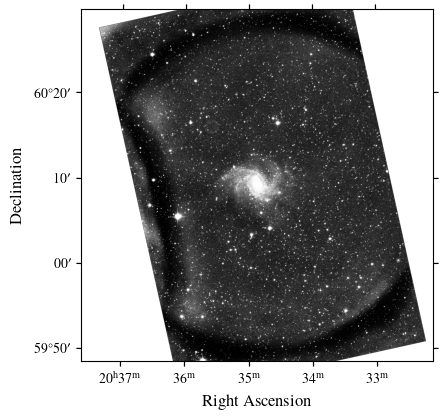

In [4]:
# data_reproj_0[isnan(data_reproj_0)] = 0

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1, projection= ref_wcs)
ax1.imshow(data_reproj_0, origin='lower', clim = (-10, 100), cmap = "grey")
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
# plt.title(f'reproj_NGC6946_{let}_exp{exp}.{num}')

In [5]:
hdu_image = fits.PrimaryHDU(data_reproj_0, header = header)
hdu_list_image = fits.HDUList([hdu_image])
hdu_list_image.writeto(path_galaxy + f"/reproj_NGC6946_{let}_exp{exp}.00_00{num}.fits", overwrite=True)

# n = (np.isnan(data_reproj_0)).sum()
# n1 = (~np.isnan(data_reproj_0)).sum()
# print(n, n1 , n/(n + n1))